# 3.1 MNIST

In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml("mnist_784",version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [2]:
X,y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [3]:
y.shape

(70000,)

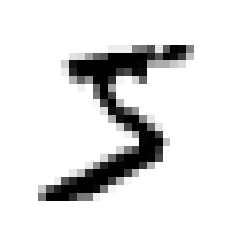

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)
plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [5]:
import numpy as np
y = y.astype(np.uint8)

In [6]:
X_train, y_train, X_test,y_test = X[:60000],y[:60000],X[60000:],y[60000:]

# 3.2 이진 분류기 훈련

In [7]:
y_train_5 = (y_train==5)
y_test_5 = (y_test==5)

In [8]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train,y_train_5)

SGDClassifier(random_state=42)

In [9]:
sgd_clf.predict([some_digit])

array([ True])

# 3.3 성능측정

## 3.3.1 교차검증을 사용한 정확도 측정

- 교차검증 구현

In [10]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_5[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train_5[test_index])

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


0.95035
0.96035
0.9604


- cross_val_score()로 kfold cross validation

In [11]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train,y_train_5,cv=3,scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [12]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X,y=None):
        return self
    def predict(self,X):
        return np.zeros((len(X),1), dtype=bool)

In [13]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train,y_train_5,cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

In [14]:
class FiveClassifier(BaseEstimator):
    def fit(self,X,y=None):
        return self
    def predict(self,X):
        return np.ones((len(X),1), dtype=bool)
_5_clf = FiveClassifier()
cross_val_score(_5_clf, X_train,y_train_5,cv=3,scoring="accuracy")

array([0.08875, 0.09145, 0.09085])

## 3.3.2 오차행렬 confusion_matrix
- 클래스 A의 샘플이 클래스 B로 분류된 횟수를 셈

In [15]:
# 예측값 생성
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train,y_train_5,cv=3)

In [16]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

## 3.3.3 정밀도와 재현율

In [17]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5,y_train_pred)

0.8370879772350012

In [18]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [19]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

decision_function()을 통해 샘플의 점수를 구한 후, 임계값(threshold)설정

In [20]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [21]:
threshold=0
y_some_digit_pred = (y_scores>threshold)
y_some_digit_pred

array([ True])

In [22]:
threshold = 8000
y_some_digit_pred = (y_scores>threshold)
y_some_digit_pred

array([False])

적절한 임계값 찾기 >> 모든 훈련세트에 있는 모든 샘플의 점수를 계산해야함

In [23]:
y_scores = cross_val_predict(sgd_clf, X_train,y_train_5, cv=3,method="decision_function") # 모든 샘플의 점수

precision_recall_curve()를 통해 모든 임계값에 대한 정밀도와 재현율 계산

In [24]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 51076 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 44228 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 44050 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:183: RuntimeWarning: Glyph 51076 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:183: RuntimeWarning: Glyph 44228 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:183: RuntimeWarning: Glyph 44050 missing from curre

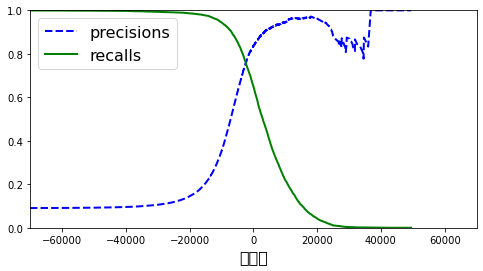

In [25]:

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="precisions", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="recalls", linewidth=2)
    plt.xlabel("임계값", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-70000, 70000])
#save_fig("precision_recall_vs_threshold_plot")
plt.show()

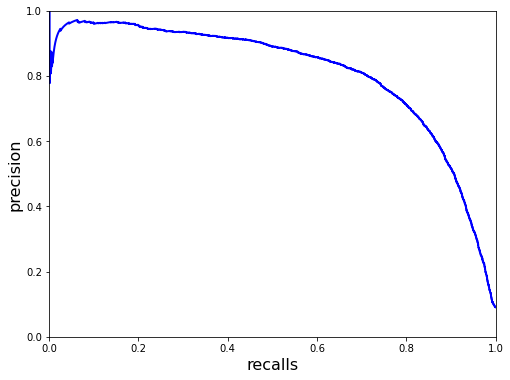

In [26]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("recalls", fontsize=16)
    plt.ylabel("precision", fontsize=16)
    plt.axis([0,1,0,1])
    
plt.figure(figsize=(8,6))
plot_precision_vs_recall(precisions, recalls)
plt.show()

정밀도 90%

In [27]:
threshold_90_precision = thresholds[np.argmax(precisions>=0.90)]
threshold_90_precision

3370.0194991439594

In [28]:
y_scores # 모든 샘플의 점수

array([  1200.93051237, -26883.79202424, -33072.03475406, ...,
        13272.12718981,  -7258.47203373, -16877.50840447])

In [29]:
y_train_pred_90 = (y_scores >= threshold_90_precision) # 모든 샘플의 점수중에서 threshold_90_precision인것만 True
y_train_pred_90

array([False, False, False, ...,  True, False, False])

In [30]:
precision_score(y_train_5, y_train_pred_90) # 정확도 측정

0.9000345901072293

In [31]:
recall_score(y_train_5, y_train_pred_90) # 재현율 측정

0.4799852425751706

## 3.3.5 ROC 곡선

In [32]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

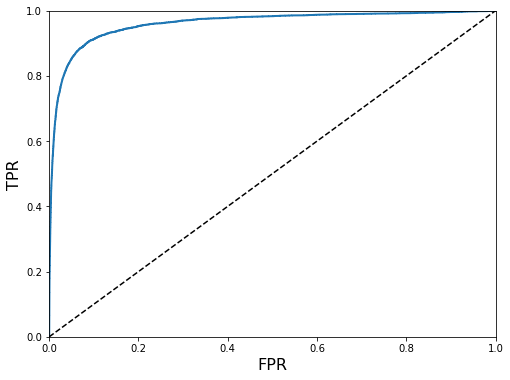

In [33]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], "k--")
    plt.axis([0,1,0,1])
    plt.xlabel("FPR", fontsize=16)
    plt.ylabel("TPR", fontsize=16)
    
plt.figure(figsize=(8,6))
plot_roc_curve(fpr,tpr)
plt.show()

In [34]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

- RandomForestClassifier의 ROC, AUC와 SGDClassifier의 비교

In [35]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

In [36]:
y_scores_forest = y_probas_forest[:,1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

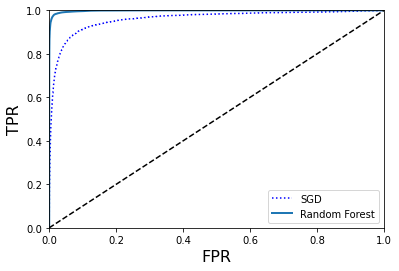

In [37]:
plt.plot(fpr,tpr,"b:",label="SGD")
plot_roc_curve(fpr_forest,tpr_forest,"Random Forest")
plt.legend(loc="lower right")
plt.show()

In [38]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

# 3.4 다중분류

In [ ]:
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train,y_train)
svm_clf.predict([some_digit])

In [ ]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

In [ ]:
np.argmax(some_digit_scores)

In [ ]:
svm_clf.classes_[5]

- OvO 강제 >> OneVsOneClassifier   
- OvR 강제 >> OneVsRestClassifier

In [ ]:
# SVC 기반 OvR전략을 사용하는 다중 분류기
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train,y_train)
ovr_clf.predict([some_digit])
len(ovr_clf.estimators_)

- SGD 분류기는 직접 샘플을 다중 클래스로 분류가능 >> OvO, OvR적용할 필요 없음

In [ ]:
sgd_clf.fit(X_train,y_train)
sgd_clf.prdict([some_digit])

In [ ]:
sgd_clf.decision_function([some_digit])